In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=084c1ba6f0625013e22842495df1c4d282ccc899e6a6c8eb77df496c27a07c09
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2025-04-27 00:30:56.672604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745713856.870420      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745713856.925911      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load dữ liệu

In [ ]:
train_data = pd.read_csv('/kaggle/input/stockdata/labeled_train.csv')
val_data = pd.read_csv('/kaggle/input/stockdata/labeled_dev.csv')
test_data = pd.read_csv('/kaggle/input/financialtest/test.csv')

### Tiền xử lý dữ liệu

##### Gán nhãn cho file test 

In [ ]:
def add_labels(df):
    delta_minutes = 30
    threshold = 0.000505
    
    df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    labels = []
    
    for idx in range(len(df)):
        current_close = df.loc[idx, 'Close']
        current_time = df.loc[idx, 'timestamp']
        
        future_idx = df.index[(df['timestamp'] >= current_time + pd.Timedelta(minutes=delta_minutes))]
        
        if len(future_idx) == 0:
            labels.append('HOLD')
        else:
            future_close = df.loc[future_idx[0], 'Close']
            if future_close > current_close * (1 + threshold):
                labels.append('BUY')
            elif future_close < current_close * (1 - threshold):
                labels.append('SELL')
            else:
                labels.append('HOLD')
    
    df['Label'] = labels
    return df

In [ ]:
test_data = add_labels(test_data)

In [ ]:
seq_len = 64
batch_size = 64

##### Thêm các chỉ báo tài chính 

In [ ]:
def add_all_indicators(df):

    # Momentum Indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()  # Relative Strength Index
    df['Momentum'] = ta.momentum.ROCIndicator(df['Close']).roc()  # Rate of Change (Momentum)
    df['CMO'] = ta.momentum.kama(df['Close'])  # Chande Momentum Oscillator
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()  # Williams %R

    # Volatility Indicators
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()  # Average True Range (ATR)
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Mid'] = bb.bollinger_mavg()  # Bollinger Bands Mid Line
    df['BB_Upper'] = bb.bollinger_hband()  # Bollinger Bands Upper Line
    df['BB_Lower'] = bb.bollinger_lband()  # Bollinger Bands Lower Line
    df['BB_Bandwidth'] = bb.bollinger_wband()  # Bollinger Bands Bandwidth
    keltner = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'])
    df['KC_High'] = keltner.keltner_channel_hband()  # Keltner Channel High Band
    df['KC_Low'] = keltner.keltner_channel_lband()  # Keltner Channel Low Band
    donchian = ta.volatility.DonchianChannel(df['High'], df['Low'], df['Close'])
    df['DC_High'] = donchian.donchian_channel_hband()  # Donchian Channel High Band
    df['DC_Low'] = donchian.donchian_channel_lband()  # Donchian Channel Low Band

    # Trend Indicators
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()  # Simple Moving Average (SMA)
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()  # Exponential Moving Average (EMA)
    df['DPO'] = ta.trend.DPOIndicator(df['Close']).dpo()  # Detrended Price Oscillator
    df['MACD'] = ta.trend.MACD(df['Close']).macd()  # MACD (Moving Average Convergence Divergence)
    df['MACD_Hist'] = ta.trend.MACD(df['Close']).macd_diff()  # MACD Histogram
    df['Mass_Index'] = ta.trend.mass_index(df['High'], df['Low'])  # Mass Index

    # Volume Indicators
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()  # Accumulation Distribution
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()  # Chaikin Money Flow (CMF)
    df['Force_Index'] = ta.volume.ForceIndexIndicator(df['Close'], df['Volume']).force_index()  # Force Index
    df['MFI'] = ta.volume.MFIIndicator(df['High'], df['Low'], df['Close'], df['Volume']).money_flow_index()  # Money Flow Index (MFI)
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()  # On-Balance Volume (OBV)

    df = df.fillna(method='bfill').fillna(method='ffill')

    return df

In [ ]:
train_data = add_all_indicators(train_data)
val_data = add_all_indicators(val_data)
test_data = add_all_indicators(test_data)
train_data

/tmp/ipykernel_19/434433610.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/tmp/ipykern

,Date,Time,Open,High,Low,Close,Volume,Label,RSI,Momentum,...,EMA_20,DPO,MACD,MACD_Hist,Mass_Index,AD,CMF,Force_Index,MFI,OBV
0,2011-01-03,01:00,1415.71,1416.54,1415.10,1415.63,1035,SELL,66.526985,0.281853,...,1417.973643,0.8310,-0.488453,-1.564897,27.094344,-273.125000,-0.021168,239.266763,70.035359,1035
1,2011-01-03,02:00,1415.64,1416.43,1414.90,1415.98,736,SELL,66.526985,0.281853,...,1417.973643,0.8310,-0.488453,-1.564897,27.094344,29.933824,-0.021168,239.266763,70.035359,1771
2,2011-01-03,03:00,1415.95,1417.89,1414.59,1416.54,922,SELL,66.526985,0.281853,...,1417.973643,0.8310,-0.488453,-1.564897,27.094344,197.570187,-0.021168,239.266763,70.035359,2693
3,2011-01-03,04:00,1416.51,1418.64,1415.25,1416.75,1060,SELL,66.526985,0.281853,...,1417.973643,0.8310,-0.488453,-1.564897,27.094344,75.623285,-0.021168,239.266763,70.035359,3753
4,2011-01-03,05:00,1416.76,1420.00,1416.76,1419.48,838,SELL,66.526985,0.281853,...,1417.973643,0.8310,-0.488453,-1.564897,27.094344,644.635630,-0.021168,239.266763,70.035359,4591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446544,2020-12-31,19:13,1891.01,1892.01,1890.74,1892.01,112,BUY,37.321866,-0.133542,...,1893.071107,1.1790,-0.593401,-0.311700,26.715393,-958167.897469,0.014368,-8.203504,33.867873,6698099
3446545,2020-12-31,19:14,1892.01,1892.64,1892.01,1892.28,77,BUY,40.537317,-0.126670,...,1892.995764,1.3500,-0.579553,-0.238281,27.095636,-958178.897469,0.022525,-4.061575,31.889678,6698176
3446546,2020-12-31,19:15,1892.19,1892.21,1891.90,1892.02,68,BUY,38.489628,-0.146190,...,1892.902834,1.1715,-0.582839,-0.193254,27.287461,-958194.252307,-0.008073,-6.007064,32.300976,6698108
3446547,2020-12-31,19:16,1892.02,1892.06,1891.43,1891.43,75,BUY,34.260370,-0.163629,...,1892.762564,1.0220,-0.625838,-0.189002,27.395799,-958269.252307,-0.083615,-11.470341,26.313034,6698033


##### Xử lý dữ liệu 

In [ ]:
def preprocessing(df):
    cols = ['Open', 'High', 'Low', 'Close']
    df[cols] = df[cols].pct_change().fillna(0) * 100

    label_map = {'SELL': 0, 'HOLD': 1, 'BUY': 2}
    df['Label'] = df['Label'].map(label_map)

    df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['hour'] = df['timestamp'].dt.hour / 23
    df['day_of_week'] = df['timestamp'].dt.dayofweek / 6
    df['index'] = np.arange(len(df)) / len(df)
    df = df.drop(columns=['Date', 'Time'])

    return df

In [ ]:
train_data = preprocessing(train_data)
val_data = preprocessing(val_data)
test_data = preprocessing(test_data)

In [ ]:
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'RSI', 'Momentum', 'CMO', 'Williams_%R',
    'ATR', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'BB_Bandwidth',
    'KC_High', 'KC_Low', 'DC_High', 'DC_Low',
    'SMA_20', 'EMA_20', 'DPO', 'MACD', 'MACD_Hist', 'Mass_Index',
    'AD', 'CMF', 'Force_Index', 'MFI', 'OBV',
    'index', 'hour', 'day_of_week'
]

##### Chuẩn hóa dữ liệu

In [ ]:
def normalize_by_blocks(data, block_size) :
    result = np.zeros_like(data)

    for start_idx in range(0, len(data), block_size):
        block = data[start_idx:start_idx + block_size]
        scaler = StandardScaler()
        normalized_block = scaler.fit_transform(block)
        result[start_idx:start_idx + block_size] = normalized_block

    return result

In [ ]:
train_data[feature_cols] = pd.DataFrame(normalize_by_blocks(train_data[feature_cols], seq_len), columns=feature_cols)
val_data[feature_cols] = pd.DataFrame(normalize_by_blocks(val_data[feature_cols], seq_len), columns=feature_cols)
test_data[feature_cols] = pd.DataFrame(normalize_by_blocks(test_data[feature_cols], seq_len), columns=feature_cols)

### Tạo sliding window

In [ ]:
def sequence_generator(df, seq_len, feature_cols):
    features = df[feature_cols].values.astype('float32')
    labels = df['Label'].values.astype('int32')

    for i in range(seq_len, len(features)):
        x = features[i - seq_len:i]
        y = labels[i]
        yield x, y

In [ ]:
def dataset_from_sequences(df, seq_len, feature_cols):
    output_signature = (
        tf.TensorSpec(shape=(seq_len, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(
        lambda: sequence_generator(df, seq_len, feature_cols),
        output_signature=output_signature
    )

In [ ]:
def create_dataset(df, seq_len, batch_size, feature_cols, shuffle=True):
    ds = dataset_from_sequences(df, seq_len, feature_cols)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_data, seq_len, batch_size, feature_cols, shuffle=True)
val_ds = create_dataset(val_data, seq_len, batch_size, feature_cols, shuffle=False)
test_ds = create_dataset(test_data, seq_len, batch_size, feature_cols, shuffle=False)

I0000 00:00:1745718733.744563      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Mô hình Transformer

In [ ]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=8, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.weights_linear = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias_linear = self.add_weight(
            shape=(1,),
            initializer='glorot_uniform',
            trainable=True
        )

        self.weights_periodic = self.add_weight(
            shape=(input_shape[-1], self.kernel_size - 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias_periodic = self.add_weight(
            shape=(self.kernel_size - 1,),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=2*np.pi),
            trainable=True
        )

    def call(self, inputs):
        linear_term = tf.matmul(inputs, self.weights_linear) + self.bias_linear
        periodic_term = tf.math.sin(tf.matmul(inputs, self.weights_periodic) + self.bias_periodic)
        return tf.concat([linear_term, periodic_term], axis=-1)

In [ ]:
def transformer_block(inputs, head_size=64, num_heads=6, ff_dim=128, dropout=0.1):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return x

In [ ]:
def build_transformer_classifier(input_shape, num_classes=3, num_blocks=4, head_size=64, num_heads=6, ff_dim=128, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    features = inputs[..., :-3]
    time_features = inputs[..., -3:]
    time_features = tf.keras.layers.Reshape((input_shape[0], 3))(time_features)

    t2v = Time2Vec(kernel_size=16)(time_features)

    x = tf.keras.layers.Concatenate(axis=-1)([features, t2v])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.Dense(128)(x)

    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

### Huấn luyện mô hình 

In [ ]:
for x_sample, _ in train_ds.take(1):
    input_shape = x_sample.shape[1:]
    model = build_transformer_classifier(input_shape=input_shape)
    with open('model.json', 'w') as f:
        f.write(model.to_json())

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 64, 3)          │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 3)          │              0 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 64, 29)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vec (Time2Vec)      │ (None, 64, 16)         │             64 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 45)         │              0 │ get_item[0][0],        │
│                           │                        │                │ time2_vec[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 45)         │             90 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 128)        │          5,888 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 128)        │        197,888 │ dense[0][0],           │
│ (MultiHeadAttention)      │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 128)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 128)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 128)        │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 128)        │         16,512 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 128)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 128)        │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 128)        │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 874,141 (3.33 MB)

 Trainable params: 874,141 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


I0000 00:00:1745718758.165442      70 service.cc:148] XLA service 0x7c2900002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745718758.166312      70 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745718759.698497      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


      7/Unknown 30s 21ms/step - accuracy: 0.3464 - loss: 1.1590

I0000 00:00:1745718768.904426      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  53852/Unknown 1116s 20ms/step - accuracy: 0.6406 - loss: 0.7757

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1211s 22ms/step - accuracy: 0.6406 - loss: 0.7757 - val_accuracy: 0.5783 - val_loss: 0.9685
Epoch 2/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7004 - loss: 0.6714

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1167s 22ms/step - accuracy: 0.7004 - loss: 0.6714 - val_accuracy: 0.5869 - val_loss: 0.9610
Epoch 3/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7161 - loss: 0.6430

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1180s 22ms/step - accuracy: 0.7161 - loss: 0.6430 - val_accuracy: 0.5984 - val_loss: 0.9422
Epoch 4/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7250 - loss: 0.6251

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1164s 22ms/step - accuracy: 0.7250 - loss: 0.6251 - val_accuracy: 0.5915 - val_loss: 0.9853
Epoch 5/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7312 - loss: 0.6124

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1173s 22ms/step - accuracy: 0.7312 - loss: 0.6124 - val_accuracy: 0.6049 - val_loss: 0.9446
Epoch 6/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53850/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7374 - loss: 0.6010

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1180s 22ms/step - accuracy: 0.7374 - loss: 0.6010 - val_accuracy: 0.6100 - val_loss: 0.9513
Epoch 7/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7416 - loss: 0.5926

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1179s 22ms/step - accuracy: 0.7416 - loss: 0.5926 - val_accuracy: 0.6178 - val_loss: 0.9242
Epoch 8/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7464 - loss: 0.5826

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1173s 22ms/step - accuracy: 0.7464 - loss: 0.5826 - val_accuracy: 0.6117 - val_loss: 0.9397
Epoch 9/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53849/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7503 - loss: 0.5749

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1180s 22ms/step - accuracy: 0.7503 - loss: 0.5749 - val_accuracy: 0.6173 - val_loss: 0.9338
Epoch 10/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7545 - loss: 0.5670

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1184s 22ms/step - accuracy: 0.7545 - loss: 0.5670 - val_accuracy: 0.6138 - val_loss: 0.9511
Epoch 11/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53849/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7582 - loss: 0.5585

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1176s 22ms/step - accuracy: 0.7582 - loss: 0.5585 - val_accuracy: 0.6248 - val_loss: 0.9229
Epoch 12/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53849/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7618 - loss: 0.5521

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1187s 22ms/step - accuracy: 0.7618 - loss: 0.5521 - val_accuracy: 0.6184 - val_loss: 0.9531
Epoch 13/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53851/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7658 - loss: 0.5428

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1185s 22ms/step - accuracy: 0.7658 - loss: 0.5428 - val_accuracy: 0.6140 - val_loss: 0.9656
Epoch 14/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7702 - loss: 0.5345

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1176s 22ms/step - accuracy: 0.7702 - loss: 0.5345 - val_accuracy: 0.6144 - val_loss: 0.9875
Epoch 15/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7726 - loss: 0.5275

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53852/53852 ━━━━━━━━━━━━━━━━━━━━ 1171s 22ms/step - accuracy: 0.7726 - loss: 0.5275 - val_accuracy: 0.6239 - val_loss: 0.9687


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### Đánh giá mô hình 

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

17615/17615 ━━━━━━━━━━━━━━━━━━━━ 323s 18ms/step - accuracy: 0.6186 - loss: 0.9363
Test Accuracy: 0.6194
Test Loss: 0.9323


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### Thử nghiệm backtesting 

In [ ]:
test_file = '/kaggle/input/financialtest/test.csv'
test_df = pd.read_csv(test_file)

In [ ]:
test_df = add_labels(test_df)

In [ ]:
def calculate_metrics(returns):
    if len(returns) <= 1:
        print("Warning: Portfolio values are empty or contain only one value. Returning default metrics.")
        return 0.0, 0.0, 0.0

    total_return = (returns.iloc[-1] / returns.iloc[0] - 1) * 100 if returns.iloc[0] != 0 else 0

    daily_returns = returns.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if len(daily_returns) > 0 and daily_returns.std() != 0 else 0

    roll_max = returns.cummax()
    drawdowns = (returns - roll_max) / roll_max
    max_drawdown = drawdowns.min() * 100 if len(drawdowns) > 0 else 0

    return total_return, sharpe_ratio, max_drawdown

In [ ]:
def backtest_model(model, test_df, seq_len, feature_cols, initial_cash=10000, transaction_cost=0.001, start_date=None, end_date=None):

    if start_date is not None and end_date is not None:
        test_df = test_df[(test_df['Date'] >= start_date) & (test_df['Date'] <= end_date)]
        print(f"Filtered test_df by date: {start_date} to {end_date}, resulting size: {len(test_df)}")
    print(f"Starting backtesting with test_df size: {len(test_df)}")

    test_df_processed = add_all_indicators(test_df.copy())
    print(f"After adding indicators, test_df_processed size: {len(test_df_processed)}")

    test_df_processed = preprocessing(test_df_processed)
    print(f"After preprocessing, test_df_processed size: {len(test_df_processed)}")

    test_df_processed[feature_cols] = pd.DataFrame(
        normalize_by_blocks(test_df_processed[feature_cols], seq_len),
        columns=feature_cols
    )

    test_ds = create_dataset(test_df_processed, seq_len, batch_size, feature_cols, shuffle=False)

    predictions = model.predict(test_ds)
    print(f"Number of predictions: {len(predictions)}")

    if len(predictions) == 0:
        print("Error: No predictions generated. Check dataset size or sequence generation.")
        return pd.Series([initial_cash]), []

    predicted_labels = np.argmax(predictions, axis=1)

    label_map = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}
    predicted_labels = [label_map[label] for label in predicted_labels]

    close_prices = test_df['Close'].iloc[seq_len:].values
    actual_labels = test_df_processed['Label'].iloc[seq_len:].values
    timestamps = test_df['Date'].iloc[seq_len:] + ' ' + test_df['Time'].iloc[seq_len:]

    print(f"Number of close prices: {len(close_prices)}")
    print(f"Number of timestamps: {len(timestamps)}")

    if len(close_prices) != len(predicted_labels):
        print(f"Error: Mismatch between close prices ({len(close_prices)}) and predictions ({len(predicted_labels)})")
        return pd.Series([initial_cash]), []

    cash = initial_cash
    position = 0 
    portfolio_values = [initial_cash]
    trades = []

    print("\nTrade Log:")
    print("-" * 80)
    print(f"{'Timestamp':<20} {'Action':<8} {'Price':<10} {'Shares':<10} {'Cash':<12} {'Portfolio Value':<15}")
    print("-" * 80)

    for i in range(len(predicted_labels)):
        price = close_prices[i]
        signal = predicted_labels[i]
        timestamp = timestamps.iloc[i]

        if signal == 'BUY' and position == 0: 
            shares_to_buy = cash // price
            if shares_to_buy > 0:
                cost = shares_to_buy * price
                cash -= cost * (1 + transaction_cost)
                position += shares_to_buy
                trades.append({
                    'timestamp': timestamp,
                    'action': 'BUY',
                    'price': price,
                    'shares': shares_to_buy,
                    'cash': cash,
                    'portfolio_value': cash + position * price
                })
                print(f"{timestamp:<20} {'BUY':<8} {price:<10.2f} {shares_to_buy:<10} {cash:<12.2f} {cash + position * price:<15.2f}")

        elif signal == 'SELL' and position > 0: 
            cash += position * price * (1 - transaction_cost)
            trades.append({
                'timestamp': timestamp,
                'action': 'SELL',
                'price': price,
                'shares': position,
                'cash': cash,
                'portfolio_value': cash
            })
            print(f"{timestamp:<20} {'SELL':<8} {price:<10.2f} {position:<10} {cash:<12.2f} {cash:<15.2f}")
            position = 0

        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)

    print("-" * 80)

    portfolio_values = pd.Series(portfolio_values)
    print(f"Number of portfolio values: {len(portfolio_values)}")

    total_return, sharpe_ratio, max_drawdown = calculate_metrics(portfolio_values)

    print("\nClassification Report:")
    print(classification_report(actual_labels, np.argmax(predictions, axis=1), target_names=['SELL', 'HOLD', 'BUY']))

    print("\nBacktesting Results:")
    print(f"Initial Cash: ${initial_cash:.2f}")
    if len(portfolio_values) > 0:
        print(f"Final Portfolio Value: ${portfolio_values.iloc[-1]:.2f}")
    else:
        print("Final Portfolio Value: Not available (no portfolio values generated)")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Number of Trades: {len(trades)}")

    print("\nTrade Summary:")
    print("-" * 80)
    print(f"{'Timestamp':<20} {'Action':<8} {'Price':<10} {'Shares':<10} {'Cash':<12} {'Portfolio Value':<15}")
    print("-" * 80)
    for trade in trades:
        print(f"{trade['timestamp']:<20} {trade['action']:<8} {trade['price']:<10.2f} {trade['shares']:<10} {trade['cash']:<12.2f} {trade['portfolio_value']:<15.2f}")
    print("-" * 80)

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid()
    plt.savefig('portfolio_value.png')

    return portfolio_values, trades

Filtered test_df by date: 2022-01-01 to 2022-03-31, resulting size: 87402
Starting backtesting with test_df size: 87402


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/tmp/ipykernel_19/434433610.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


After adding indicators, test_df_processed size: 87402
After preprocessing, test_df_processed size: 87402
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Number of predictions: 87338
Number of close prices: 87338
Number of timestamps: 87338

Trade Log:
--------------------------------------------------------------------------------
Timestamp            Action   Price      Shares     Cash         Portfolio Value
--------------------------------------------------------------------------------
2022-01-03 01:14     BUY      1827.51    5.0        862.45       10000.00       
2022-01-03 01:57     SELL     1830.29    5.0        10013.90     10013.90       
2022-01-03 04:27     BUY      1825.26    5.0        887.60       10013.90       
2022-01-03 05:29     SELL     1825.71    5.0        10016.15     10016.15       
2022-01-03 06:26     BUY      1824.20    5.0        895.15       10016.15       
2022-01-03 06:49     SELL     1825.63    5.0        10023.30     10023.30       
2022-01-03 07:16     BUY      1824.61    5.0        900.25       10023.30       
2022-01-03 07:36     SELL     1824.36    5.0        10022.05     10022.05       
2022-01-03

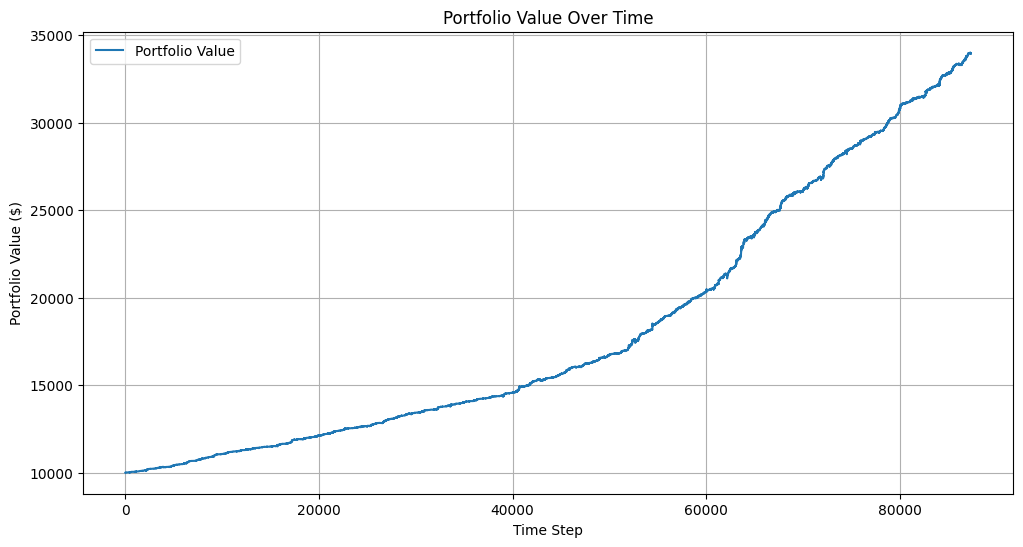

In [ ]:
portfolio_values, trades = backtest_model(
    model,
    test_df,
    seq_len,
    feature_cols,
    initial_cash=10000,
    transaction_cost=0,
    start_date="2022-01-01",
    end_date="2022-03-31"
)